In [8]:
import warnings

warnings.filterwarnings("ignore")

import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot


converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383187  S^2 = 0.0000000


In [9]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

print(t1)
print(t2)

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988299
[[ 1.60783196e-32 -1.85853569e-16  4.83181491e-15  1.12120558e-03
   1.74297865e-30 -1.05160380e-46 -2.50679695e-03  6.84724218e-34
  -8.20932104e-18  3.64310171e-15  3.09289147e-15]
 [-8.70863052e-47  1.16242358e-30 -3.23797234e-03 -8.00393229e-16
  -2.60786089e-17  2.07918272e-33 -1.02506453e-16 -3.37066535e-47
   4.73616728e-31  4.62890470e-03 -3.94380383e-03]
 [-7.64623369e-32  1.63836784e-15  7.25356931e-16 -2.36554155e-29
   1.89984870e-02 -2.44608027e-32 -4.44708698e-30  3.27186604e-32
  -1.69077589e-15  3.88069744e-16  1.33529139e-16]
 [ 6.01503960e-17 -7.74350496e-32 -4.44924826e-32  1.43881790e-45
  -2.82371044e-32  1.89984870e-02  2.96046267e-46 -1.12323746e-15
   4.41255257e-32 -2.38412174e-32 -7.78283693e-33]
 [ 8.71177275e-33 -6.37351516e-17 -1.59435746e-16  1.34162761e-03
  -6.51100954e-31  4.12243438e-47  9.02827417e-03 -5.45819150e-33
   6.30228768e-17 -1.52997242e-15 -1.85913997e-15]]
[[[[-7.03891689e-03  3.86

In [10]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import QiskitRuntimeService

backend = FakeSherbrooke()

# service = QiskitRuntimeService(channel='ibm_cloud', token="G_1ihMPCjm6ZX8YOKO8fbc6w7Z6HPpXZLX1YMAmCoHxH", instance="00_Hackathon 2025-1-eu")
# backend = service.least_busy(simulator=False, operational=True)

In [62]:
backend

<IBMBackend('ibm_strasbourg')>

In [12]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('rz', 4460), ('sx', 3434), ('ecr', 1366), ('x', 250), ('measure', 32), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('rz', 2446), ('sx', 2171), ('ecr', 730), ('x', 89), ('measure', 32), ('barrier', 1)])


In [64]:
import numpy as np
from qiskit_addon_sqd.counts import generate_bit_array_uniform

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=10_000)
primitive_result = job.result()
pub_result = primitive_result[0]
bit_array = pub_result.data.meas

# rng = np.random.default_rng(24)
# bit_array = generate_bit_array_uniform(10_000, num_orbitals * 2, rand_seed=rng)
print(bit_array)

BitArray(<shape=(), num_shots=10000, num_bits=32>)


In [16]:
from qiskit.primitives.containers import BitArray
import numpy as np

coba = np.load("bit_array.npy")
bit_array = BitArray(coba, 32)
rng = np.random.default_rng(24)

In [17]:
from functools import partial

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 10

# Eigenstate solver options
num_batches = 6
samples_per_batch = 700
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        # print(f"Help : {help(result)}")
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

print(f"hcore: {hcore.shape}")
print(f"eri: {eri.shape}")
print(f"bit_array: {bit_array}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

hcore: (16, 16)
eri: (16, 16, 16, 16)
bit_array: BitArray(<shape=(), num_shots=10000, num_bits=32>)


Iteration 1
	Subsample 0
		Energy: -106.64788906072718
		Subspace dimension: 4624
	Subsample 1
		Energy: -106.64788906072718
		Subspace dimension: 4624
	Subsample 2
		Energy: -106.64788906072718
		Subspace dimension: 4624
	Subsample 3
		Energy: -106.64788906072718
		Subspace dimension: 4624
	Subsample 4
		Energy: -106.64788906072718
		Subspace dimension: 4624
	Subsample 5
		Energy: -106.64788906072718
		Subspace dimension: 4624
Iteration 2
	Subsample 0
		Energy: -108.9909073573064
		Subspace dimension: 956484
	Subsample 1
		Energy: -108.94749403027522
		Subspace dimension: 915849
	Subsample 2
		Energy: -108.96445248065604
		Subspace dimension: 962361
	Subsample 3
		Energy: -108.95406749071137
		Subspace dimension: 919681
	Subsample 4
		Energy: -108.9686075915195
		Subspace dimension: 921600
	Subsample 5
		Energy: -108.97005945632637
		Subspace dimension: 919681
Iteration 3
	Subsample 0
		Energy: -109.03465062530353
		Subspace dimension: 1283689
	Subsample 1
		Energy: -109.0348821311212

KeyboardInterrupt: 

Exact energy: -109.04667 Ha
SQD energy: -109.04520 Ha
Absolute error: 0.00147 Ha


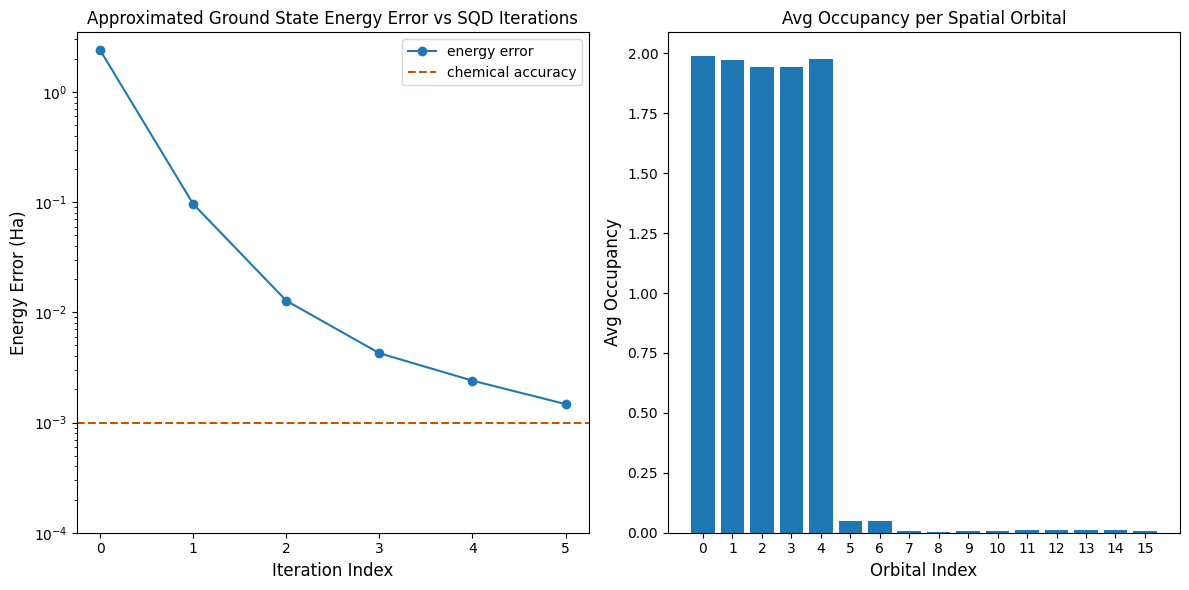

In [91]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()